In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))
from pipeline import Pipeline

/Users/sahmed08/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-10-31 21:24:51.250396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pipeline = Pipeline()

corpus_directory = '../storage/corpus' 

In [3]:
def display_chunks(corpus_directory, chunking_strategy, fixed_length=None, overlap_size=2):
    print(f"Chunking strategy: {chunking_strategy}, Fixed length: {fixed_length}, Overlap size: {overlap_size}")
    chunks = pipeline.preprocess_corpus(
        corpus_directory=corpus_directory,
        chunking_strategy=chunking_strategy,
        fixed_length=fixed_length,
        overlap_size=overlap_size
    )
    
    for idx, chunk in enumerate(chunks[:5]):
        print(f"Chunk {idx + 1}: {chunk['chunk'][:100]}...")
    print("\n" + "="*80 + "\n")

In [4]:
display_chunks(corpus_directory, chunking_strategy='sentence', overlap_size=2)

display_chunks(corpus_directory, chunking_strategy='sentence', overlap_size=4)

display_chunks(corpus_directory, chunking_strategy='fixed-length', fixed_length=50, overlap_size=3)

display_chunks(corpus_directory, chunking_strategy='fixed-length', fixed_length=100, overlap_size=2)

display_chunks(corpus_directory, chunking_strategy='fixed-length', fixed_length=150, overlap_size=1)

Chunking strategy: sentence, Fixed length: None, Overlap size: 2
Chunk 1: Grover Cleveland Stephen Grover Cleveland (March 18 1837 June 24 1908), the twenty-second and twenty...
Chunk 2: He was the only Democrat elected to the Presidency in the era of Republican political domination bet...
Chunk 3: As a leader of the Bourbon Democrats, he opposed imperialism, taxes, corruption, patronage, subsidie...
Chunk 4: Such criticisms include but are not limited to: his intervention in the Pullman Strike of 1894 in or...
Chunk 5: He lost control of his party to the agrarians and silverites in 1896. An early, undated photograph o...


Chunking strategy: sentence, Fixed length: None, Overlap size: 4
Chunk 1: Grover Cleveland Stephen Grover Cleveland (March 18 1837 June 24 1908), the twenty-second and twenty...
Chunk 2: As a leader of the Bourbon Democrats, he opposed imperialism, taxes, corruption, patronage, subsidie...
Chunk 3: He lost control of his party to the agrarians and silverites in 1896

In [5]:
import matplotlib.pyplot as plt
from modules.retrieval.reranker import Reranker
import pandas as pd

In [6]:
questions_path = '../qa_resources/questions.csv'
corpus_directory = '../storage/corpus'

In [7]:
questions = pd.read_csv(questions_path, sep='\t')
sample_query = questions['Question'][0]

In [8]:
sample_documents = []
for filename in os.listdir(corpus_directory):
    with open(os.path.join(corpus_directory, filename), 'r') as file:
        sample_documents.append(file.read())

In [9]:
cross_encoder_reranker = Reranker(type="cross_encoder")
tfidf_reranker = Reranker(type="tfidf")
hybrid_reranker = Reranker(type="hybrid")
sequential_reranker = Reranker(type="sequential")
tfidf_corpus_reranker = Reranker(type="tfidf_corpus")

In [10]:
def plot_reranking_results(results, title):
    documents, indices, scores = results
    plt.figure(figsize=(10, 5))
    plt.plot(scores, marker='o')
    plt.title(title)
    plt.xlabel("Ranked Document Index")
    plt.ylabel("Relevance Score")
    plt.show()

Sample Query: Was Abraham Lincoln the sixteenth President of the United States?


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

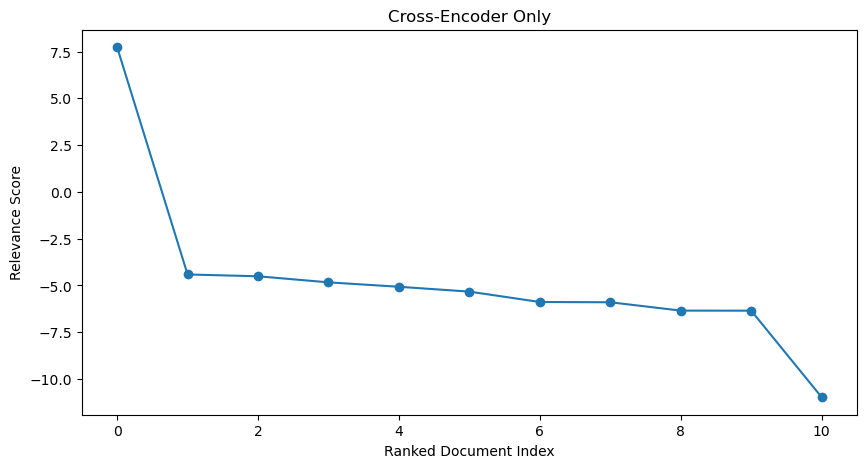

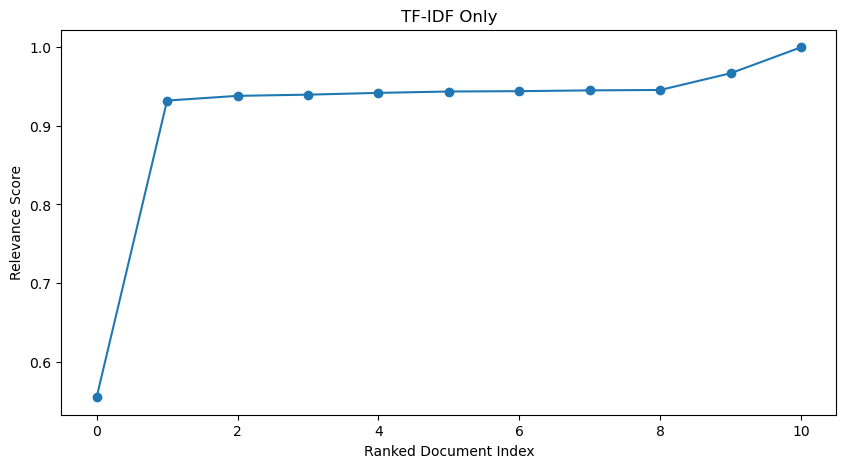

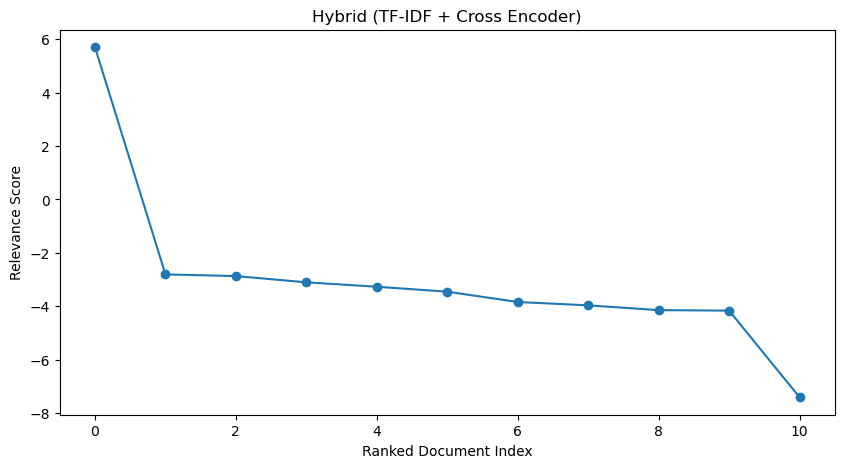

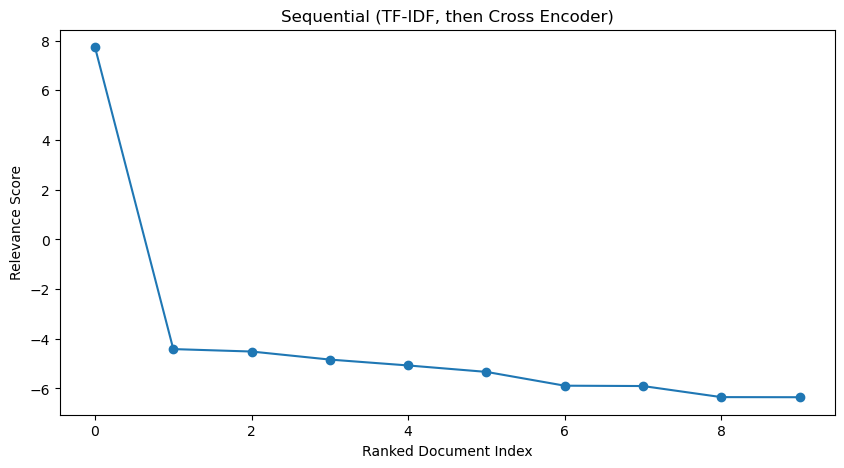

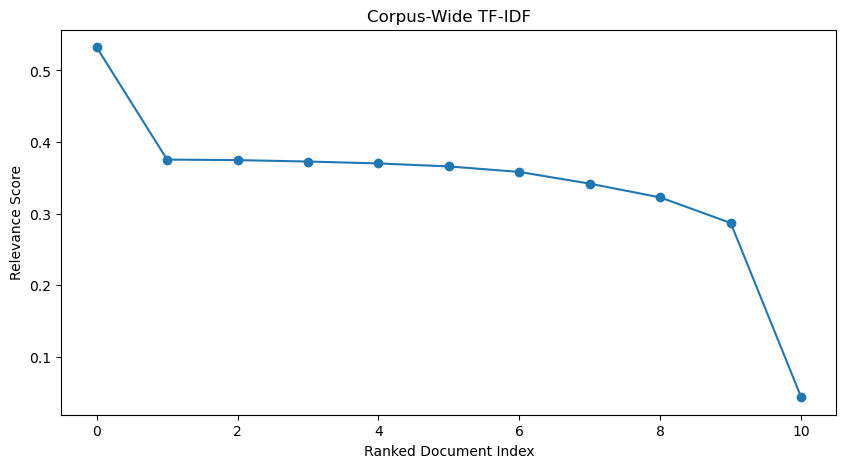

In [11]:
print("Sample Query:", sample_query)

cross_encoder_results = cross_encoder_reranker.rerank(sample_query, sample_documents)
plot_reranking_results(cross_encoder_results, "Cross-Encoder Only")

tfidf_results = tfidf_reranker.rerank(sample_query, sample_documents)
plot_reranking_results(tfidf_results, "TF-IDF Only")

hybrid_results = hybrid_reranker.rerank(sample_query, sample_documents)
plot_reranking_results(hybrid_results, "Hybrid (TF-IDF + Cross Encoder)")

sequential_results = sequential_reranker.sequential_rerank(sample_query, sample_documents)
plot_reranking_results(sequential_results, "Sequential (TF-IDF, then Cross Encoder)")

tfidf_corpus_results = tfidf_corpus_reranker.tfidf_corpus_rerank(sample_query, sample_documents)
plot_reranking_results(tfidf_corpus_results, "Corpus-Wide TF-IDF")

Cross-Encoder Only

The cross-encoder achieves high relevance for top results by leveraging deep semantic similarity, making it ideal for precise ranking. However, it's computationally intensive and thus impractical for large document sets. In system design, the cross-encoder is best suited for re-ranking a small set of top candidates obtained from an initial, faster method.

TF-IDF Only

TF-IDF provides stable, high scores for many documents due to its reliance on keyword overlap, making it efficient and scalable for large corpora. However, it lacks semantic depth and may miss nuanced relevance. TF-IDF is well-suited as a preliminary filter to quickly reduce candidates before applying more precise ranking methods.

Hybrid (TF-IDF + Cross-Encoder)

The hybrid approach combines TF-IDF filtering with cross-encoder re-ranking, balancing speed with precision. It offers an effective compromise between relevance and efficiency, but still incurs the cross-encoder’s computational cost. This strategy is ideal when both ranking accuracy and processing speed are critical.

Sequential (TF-IDF, then Cross-Encoder)

This method first uses TF-IDF to select top candidates, then applies the cross-encoder for fine-grained re-ranking. It achieves strong relevance with a smooth score drop across results, offering a good balance of speed and precision. Sequential ranking is recommended for scenarios requiring highly relevant top results with controlled computational costs.

Corpus-Wide TF-IDF

Using TF-IDF across the entire corpus is fast and efficient but yields lower relevance precision due to its reliance on keywords. This approach is best for applications where speed is prioritized over accuracy or as a first pass to narrow down large document sets before more detailed ranking.

For optimal system design, begin with TF-IDF or Corpus-Wide TF-IDF to quickly filter a large corpus, reducing the candidate pool for further processing. For applications that need high precision in top results, follow this initial filtering with a Hybrid or Sequential (TF-IDF, then Cross-Encoder) approach, which balances efficiency with semantic relevance. Finally, apply the Cross-Encoder solely for re-ranking the top candidates, maximizing relevance while minimizing computational cost. This layered strategy ensures the system is both scalable and accurate, adjusting processing depth based on the required precision and available resources.